<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Intro-to-Pytorch" data-toc-modified-id="Intro-to-Pytorch-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Intro to Pytorch</a></span><ul class="toc-item"><li><span><a href="#Pytorch-tensors" data-toc-modified-id="Pytorch-tensors-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Pytorch tensors</a></span></li><li><span><a href="#Pytorch-Autograd" data-toc-modified-id="Pytorch-Autograd-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Pytorch Autograd</a></span></li></ul></li><li><span><a href="#Linear-Regression-with-Pytorch" data-toc-modified-id="Linear-Regression-with-Pytorch-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Linear Regression with Pytorch</a></span><ul class="toc-item"><li><span><a href="#Gradient-Descent-with-Pytorch" data-toc-modified-id="Gradient-Descent-with-Pytorch-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Gradient Descent with Pytorch</a></span></li><li><span><a href="#Simplified-GD-Loop" data-toc-modified-id="Simplified-GD-Loop-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Simplified GD Loop</a></span></li><li><span><a href="#Your-Turn:-Write-Gradient-Descent-for-classification" data-toc-modified-id="Your-Turn:-Write-Gradient-Descent-for-classification-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Your Turn: Write Gradient Descent for classification</a></span></li></ul></li><li><span><a href="#Data-loaders-for-SGD" data-toc-modified-id="Data-loaders-for-SGD-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data loaders for SGD</a></span></li><li><span><a href="#References" data-toc-modified-id="References-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>References</a></span></li></ul></div>

In [1]:
# import pytorch libraries
%matplotlib inline
import torch 
import torch.autograd as autograd 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

# Intro to Pytorch

PyTorch consists of 4 main packages:
* torch: a general purpose array library similar to Numpy that can do computations on GPU
* torch.autograd: a package for automatically obtaining gradients
* torch.nn: a neural net library with common layers and cost functions
* torch.optim: an optimization package with common optimization algorithms like SGD, Adam, etc

## Pytorch tensors
Like Numpy tensors but can utilize GPUs to accelerate its numerical computations. 

In [2]:
# Create random tensor
N = 5
x = torch.randn(N, 10).type(torch.FloatTensor)

In [3]:
x

tensor([[ 0.6691, -0.1280,  0.8421,  2.2851,  1.7757,  0.9769,  0.3502,
         -0.7883,  1.6040,  0.3612],
        [ 1.4481, -0.4466,  0.3664,  0.9222,  1.1099,  0.2272, -1.3081,
         -0.3249,  0.3505,  0.3799],
        [ 0.9878,  0.5443, -1.2017, -1.0816, -0.3944, -0.8745,  2.3425,
          0.7038, -0.2948,  0.8728],
        [ 0.0370,  0.0597,  0.8080,  0.1648,  0.5605, -0.6617, -1.3530,
         -0.1071, -0.2501,  0.5874],
        [-1.1840, -0.3086, -0.6045, -0.9292, -0.0677, -0.5508, -2.2708,
          0.5521,  1.0586,  1.5647]])

In [4]:
# reshaping of tensors using .view()
x.view(1,-1) #-1 makes torch infer the second dim

tensor([[ 0.6691, -0.1280,  0.8421,  2.2851,  1.7757,  0.9769,  0.3502,
         -0.7883,  1.6040,  0.3612,  1.4481, -0.4466,  0.3664,  0.9222,
          1.1099,  0.2272, -1.3081, -0.3249,  0.3505,  0.3799,  0.9878,
          0.5443, -1.2017, -1.0816, -0.3944, -0.8745,  2.3425,  0.7038,
         -0.2948,  0.8728,  0.0370,  0.0597,  0.8080,  0.1648,  0.5605,
         -0.6617, -1.3530, -0.1071, -0.2501,  0.5874, -1.1840, -0.3086,
         -0.6045, -0.9292, -0.0677, -0.5508, -2.2708,  0.5521,  1.0586,
          1.5647]])

## Pytorch Autograd
The autograd package in PyTorch automates the computation of backward passes in neural networks. That is, the gradient of the error with respect to all parameters.

In order for this to happen we need to wrapp up our data and paramerers with the aurograd.Variable() function. Each variable has a `.grad` property which is it’s gradient with respect to our Error function. Each variable also has a `.data` property which is it the actual value of the tensor.

In [23]:
x = torch.tensor([1., 2., 3., 4., 5., 6.], requires_grad=True)

In [24]:
x.grad

In [25]:
l = (2*x+1).sum()
l

tensor(48.)

In [26]:
l.backward()

In [27]:
x.grad

tensor([ 2.,  2.,  2.,  2.,  2.,  2.])

#  Linear Regression with Pytorch

The goal of linear regression is to fit a line to a set of points.

In [29]:
# Here we generate some fake data
def lin(a,b,x): return a*x+b

def gen_fake_data(n, a, b):
    x = np.random.uniform(0,1,n) 
    y = lin(a,b,x) + 0.1 * np.random.normal(0,3,n)
    return x, y

x, y = gen_fake_data(50, 3., 8.)

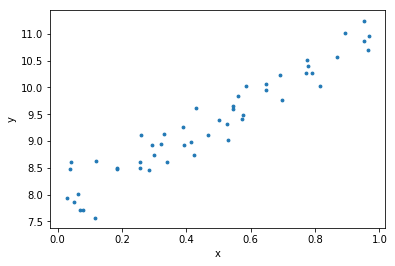

In [30]:
import matplotlib.pyplot as plt
plt.scatter(x,y, s=8); plt.xlabel("x"); plt.ylabel("y"); 

You want to find **parameters** (weights) $a$ and $b$ such that you minimize the *error* between the points and the line $a\cdot x + b$. Note that here $a$ and $b$ are unknown. For a regression problem the most common *error function* or *loss function* is the **mean squared error**. 

In [31]:
def mse(y_hat, y): return ((y_hat - y) ** 2).mean()

Suppose we believe $a = 10$ and $b = 5$ then we can compute `y_hat` which is our *prediction* and then compute our error.

In [32]:
y_hat = lin(10,5,x)
mse(y_hat, y)

3.8612793257637628

In [33]:
def mse_loss(a, b, x, y): return mse(lin(a,b,x), y)

In [34]:
mse_loss(10, 5, x, y)

3.8612793257637628

So far we have specified the *model* (linear regression) and the *evaluation criteria* (or *loss function*). Now we need to handle *optimization*; that is, how do we find the best values for $a$ and $b$? How do we find the best *fitting* linear regression.

## Gradient Descent with Pytorch

For a fixed dataset $x$ and $y$ `mse_loss(a,b)` is a function of $a$ and $b$. We would like to find the values of $a$ and $b$ that minimize that function.

**Gradient descent** is an algorithm that minimizes functions. Given a function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the function. This iterative minimization is achieved by taking steps in the negative direction of the function gradient.

Here is gradient descent implemented in [PyTorch](http://pytorch.org/).

In [43]:
# generate some more data
x, y = gen_fake_data(10000, 3., 8.)
x.shape, y.shape

((10000,), (10000,))

In [44]:
# Wrap x and y as tensor 
x = torch.tensor(x)
y = torch.tensor(y)

In [45]:
# Create random Tensors for weights, and wrap them in Variables.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Variables during the backward pass.
a, b = np.random.randn(1), np.random.randn(1)
a = torch.tensor(a, requires_grad=True)
b = torch.tensor(b, requires_grad=True)
a,b

(tensor([-0.6953], dtype=torch.float64),
 tensor([-0.8267], dtype=torch.float64))

In [46]:
learning_rate = 1e-3
for t in range(10000):
    # Forward pass: compute predicted y using operations on Variables
    loss = mse_loss(a,b,x,y)
    if t % 1000 == 0: print(loss.item())
    
    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    # After this call a.grad and b.grad will be Variables holding the gradient
    # of the loss with respect to a and b respectively
    loss.backward()
    
    # Update a and b using gradient descent; a.data and b.data are Tensors,
    # a.grad and b.grad are Variables and a.grad.data and b.grad.data are Tensors
    a.data -= learning_rate * a.grad.data
    b.data -= learning_rate * b.grad.data
    
    # Zero the gradients
    a.grad.data.zero_()
    b.grad.data.zero_()    

115.13005835055309
0.8481116873337502
0.12535420597222913
0.11325440917814708
0.10737550269233916
0.10290239421328551
0.09948305490517353
0.09686913974497124
0.09487093074323673
0.0933433986773463


In [47]:
print(a,b)

tensor([ 3.2091], dtype=torch.float64) tensor([ 7.8861], dtype=torch.float64)


## Simplified GD Loop

In [48]:
model = torch.nn.Sequential(
    torch.nn.Linear(1, 1),
)
model

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

In [49]:
print([p for p in model.parameters()])

[Parameter containing:
tensor([[-0.8327]]), Parameter containing:
tensor([ 0.5259])]


In [57]:
x, y = gen_fake_data(10000, 3., 8.)
x = torch.tensor(x).float()
y = torch.tensor(y).float()
x.shape

torch.Size([10000])

In [58]:
# you have to be careful with the dimensions that your model is expecting
x1 = torch.unsqueeze(x, 1)
x1.shape

torch.Size([10000, 1])

In [60]:
y_hat = model(x1)
print(y_hat)

tensor([[ 0.4459],
        [-0.0055],
        [ 0.0243],
        ...,
        [-0.0080],
        [ 0.4200],
        [ 0.0577]])


In [61]:
# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [62]:
for t in range(10000):
    # Forward pass: compute predicted y using operations on Variables
    y_hat = model(x1)
    loss = F.mse_loss(y_hat, y.unsqueeze(1))
    if t % 1000 == 0: print(loss.item())
       
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables
    optimizer.zero_grad()
    loss.backward()
    
    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

89.5484390258789
0.08869196474552155
0.08868811279535294
0.08868812024593353
0.08868817985057831
0.08868815004825592
0.08868815004825592
0.08868814259767532
0.08868814259767532
0.08868814259767532


In [63]:
print([p for p in model.parameters()])

[Parameter containing:
tensor([[ 3.0018]]), Parameter containing:
tensor([ 8.0035])]


## Your Turn: Write Gradient Descent for classification

In [64]:
n=10
x1 = np.random.uniform(0,1,n)
x2 = np.random.uniform(0,1,n)

In [73]:
x1 = np.random.uniform(0,1, (n, 2))
x1[:,0].shape

(10,)

In [100]:
# generating fake data
# Here we generate some fake data
def lin(a,b,x): return a*x+b

def gen_logistic_fake_data(n, a, b):
    x = np.random.uniform(-1,1, (n, 2))
    x2_hat = lin(a,b, x[:,0])
    y = x[:,1] > x2_hat
    return x, y.astype(int)

x, y = gen_logistic_fake_data(100, 1., 0.5)

In [101]:
y

array([1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0])

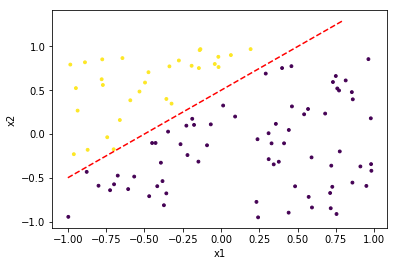

In [104]:
t = np.arange(-1, 1, 0.2)
import matplotlib.pyplot as plt
plt.scatter(x[:,0],x[:,1],c=y, s=8);
plt.xlabel("x1"); plt.ylabel("x2");
plt.plot(t, t + 0.5, 'r--')

# Data loaders for SGD

Nearly all of deep learning is powered by one very important algorithm: **stochastic gradient descent (SGD)**. SGD can be seeing as an approximation of **gradient descent** (GD). In GD you have to run through *all* the samples in your training set to do a single itaration. In SGD you use *only one* or *a subset*  of training samples to do the update for a parameter in a particular iteration. The subset use in every iteration is called a **batch** or **minibatch**.

In [ ]:
model2 = torch.nn.Sequential(
    torch.nn.Linear(1, 1),
)

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
def lin(a,b,x): return a*x+b

def gen_fake_data(n, a, b):
    x = np.random.uniform(0,1,n) 
    y = lin(a,b,x) + 0.1 * np.random.normal(0,3,n)
    return x.astype(np.float32), y.astype(np.float32)

# create a dataset
class RegressionDataset(Dataset):
    def __init__(self, a=3, b=8, n=10000):
        x, y = gen_fake_data(n, a, b)
        x = torch.from_numpy(x).unsqueeze(1)
        y = torch.from_numpy(y)
        self.x, self.y = x, y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
fake_dataset = RegressionDataset()

Next we are going to create a data loader. The data loader provides the following features:
* Batching the data
* Shuffling the data
* Load the data in parallel using multiprocessing workers.

In [ ]:
dataloader = DataLoader(fake_dataset, batch_size=1000, shuffle=True)
x, y = next(iter(dataloader))

In [ ]:
y.type(torch.FloatTensor)

In [ ]:
learning_rate = 0.1
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [ ]:
for t in range(1000):
    for i, (x, y) in enumerate(dataloader): 
        x = Variable(x, requires_grad=False)
        y = Variable(y, requires_grad=False)
        y = y.type(torch.FloatTensor)
        
        y_hat = model2(x)
        loss = F.mse_loss(y_hat, y)
    
        optimizer.zero_grad()
        loss.backward()
    
        optimizer.step()
    if t % 100 == 0: print(loss.data[0])

# References
* http://pytorch.org/tutorials/beginner/pytorch_with_examples.html
* https://hsaghir.github.io/data_science/pytorch_starter/